✅ 数据库连接成功


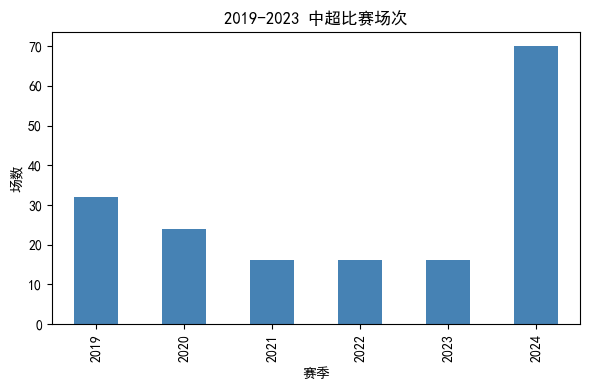

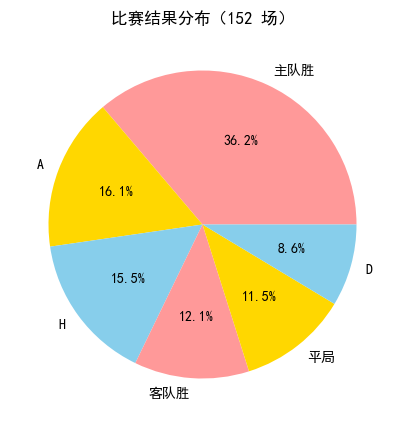

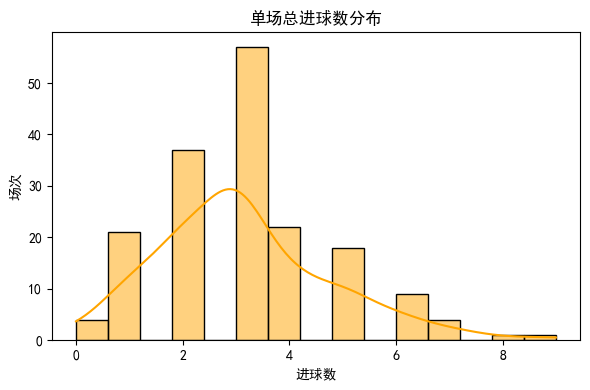

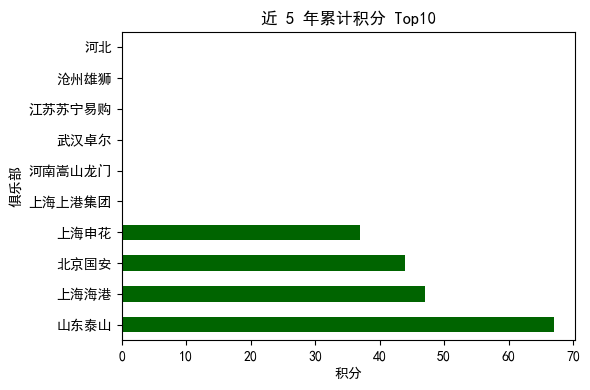

In [5]:
# ===============  1. 基础 import ===============
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# ===============  2. 让图里能显示中文 ===============
# 默认字体是英文字体，中文会乱码，所以强制换成系统黑体 SimHei
plt.rcParams['font.sans-serif'] = ['SimHei']
# 坐标轴负号默认是 Unicode 方块，打开这个开关就能正常显示“-”
plt.rcParams['axes.unicode_minus'] = False

# ===============  3. 把“数据库工具箱”拿进来 ===============
# 你自己的模块在 E 盘，不在当前目录，所以要临时把路径加进来
sys.path.append(r'E:\miniconda\ChineseSuperLeague')
from database_manager import DatabaseManager   # 自写的数据库连接类

db = DatabaseManager()                         # 实例化，拿到连接对象 db.connection

# ===============  4. 用原始 SQL 把比赛明细拉出来 ===============
cursor = db.connection.cursor()                # 要执行 SQL 先拿“光标”
cursor.execute("""
    SELECT season, round_name, match_date, 
           ht.team_name AS home, at.team_name AS away,
           m.home_score, m.away_score, m.result
    FROM matches m
    JOIN teams ht ON m.home_team_id = ht.team_id
    JOIN teams at ON m.away_team_id = at.team_id
    ORDER BY season, match_date
""")

# cursor.fetchall() 得到 [(2024, '第1轮', datetime(...), '泰山', '三镇', 2, 1, 'H'), ...]
# 直接塞给 pandas，行列自动对齐，column 名用数字 0~7
df = pd.DataFrame(cursor.fetchall())
cursor.close()                                 # 用完记得关光标

# 为了后面写代码直观，手动把列名改成中文或英文
df.columns = ['season', 'round', 'match_date',
              'home', 'away', 'home_score', 'away_score', 'result']

# ===============  5. 图 ① 每年比赛场次 ===============
plt.figure(figsize=(6, 4))                     # 新建画布 6×4 英寸
season_counts = df['season'].value_counts().sort_index()  # 按赛季统计场数并排序
season_counts.plot(kind='bar', color='steelblue')         # 柱状图
plt.title('2019-2023 中超比赛场次')
plt.xlabel('赛季'); plt.ylabel('场数')
plt.tight_layout(); plt.show()                 # tight_layout 防止文字重叠

# ===============  6. 图 ② 主胜/平/客胜比例饼图 ===============
plt.figure(figsize=(5, 5))
result_counts = df['result'].value_counts()    # 数一下 H/D/A 各多少场
plt.pie(result_counts,
        labels=result_counts.index,            # H D A 当标签
        autopct='%1.1f%%',                     # 显示百分比
        colors=['#FF9999', '#FFD700', '#87CEEB'])
plt.title('比赛结果分布（152 场）')
plt.show()

# ===============  7. 图 ③ 单场总进球分布 ===============
df['total_goals'] = df['home_score'] + df['away_score']  # 新增一列“总进球”
plt.figure(figsize=(6, 4))
# seaborn 的histplot = 直方图 + 核密度曲线，bins=15 把 0~8 球切成 15 段
sns.histplot(df['total_goals'], bins=15, kde=True, color='orange')
plt.title('单场总进球数分布')
plt.xlabel('进球数'); plt.ylabel('场次')
plt.tight_layout(); plt.show()

# ===============  8. 图 ④ 近 5 年积分榜 ===============
# 先给每种结果定积分：主胜 3，平 1，客胜 0
points = {'H': 3, 'D': 1, 'A': 0}
# 主队积分：如果 result=H 则 3 分，D 1 分，A 0 分
df['home_pts'] = df['result'].map(points)
# 客队积分相反：H→0，D→1，A→3
df['away_pts'] = df['result'].map({'H': 0, 'D': 1, 'A': 3})

# 分别按“主队名”和“客队名”累加积分
home_sum = (df.groupby('home')[['home_pts']].sum()
              .rename(columns={'home_pts': 'pts'}))
away_sum = (df.groupby('away')[['away_pts']].sum()
              .rename(columns={'away_pts': 'pts'}))

# 把主、客积分加在一起，缺值填 0，再降序排，取前 10 名
total = home_sum.add(away_sum, fill_value=0).sort_values('pts', ascending=False).head(10)

# 横向条形图看起来更顺眼
plt.figure(figsize=(6, 4))
total['pts'].plot(kind='barh', color='darkgreen')
plt.title('近 5 年累计积分 Top10')
plt.xlabel('积分'); plt.ylabel('俱乐部')
plt.tight_layout(); plt.show()